# Introduction
- This notebook aims to perform cluster analysis on the cleaned COMAH sites dataset.
    - see "COMAH site data cleaning.ipynb", the output of that notebook is the input to this notebook.
- The data consists of geographical co-ordinates of 800 COMAH facilities as of Jan 2021.
- The purpose of this notebook is to understand if the facilities lie in any natural geographic clusters.
    - When working in two dimensions (x,y co-ordinates in this case) then clustering may seem trivial, however this example serves as a useful introduction to clustering.<br>

### __Further work__
- Whilst this notebook was initially intended to support intuition of clustering basics, new sources of data have been identified which could support more complex analysyis.
- Additional data is being sourced through the development of a web scraping script, this data contains Hazardous material information, mitigation plan descriptions and inspection date data.
- Including these in the cluster analysis would require some NLP, which would increase the compledity. This additional analysis may be treated as a new branch to this work.
- Currently the website is under maintenance and web scraping cannot take place (04/10/2021).

# Import modules

In [46]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Read in clean data

In [2]:
df = pd.read_csv('comah_sites_clean.csv',index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Operator Name    800 non-null    object 
 1   Location Name    800 non-null    object 
 2   COMAH tier       800 non-null    object 
 3   Local Authority  799 non-null    object 
 4   Country          800 non-null    object 
 5   postcode         800 non-null    object 
 6   latitude         800 non-null    float64
 7   longitude        800 non-null    float64
 8   x                800 non-null    float64
 9   y                800 non-null    float64
dtypes: float64(4), object(6)
memory usage: 50.0+ KB


# View upper and lower tier sites

- Before we proceed onto clutering, we will show the sites in their x,y coordinates, showing the lower and upper tier sites

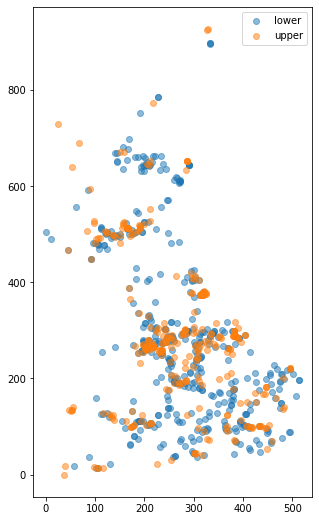

In [11]:
x_size = 5
y_size = x_size * df['y'].max()/df['x'].max()
fig,ax=plt.subplots(figsize=(x_size,y_size))
for n,g in df.groupby('COMAH tier'):
    ax.scatter(g['x'],g['y'],alpha=0.5,label=n)
a = plt.legend()

- Notice that we could almost draw on the clusters by hand, as we can visually see the 2 dimensions (x,y).
- Below, we have reproduced this graph with a third dimension, z, which splits out the upper and lower tier sites.
- Thes makes the clustering more difficult, in reality we would typically have much more featues (or dimensions), for example the "Whisky distillery" example has 12 dimensions, and this is still a relatively low number of dimensions.

In [12]:
df['z'] = df['COMAH tier'].replace('upper',1).replace('lower',0)

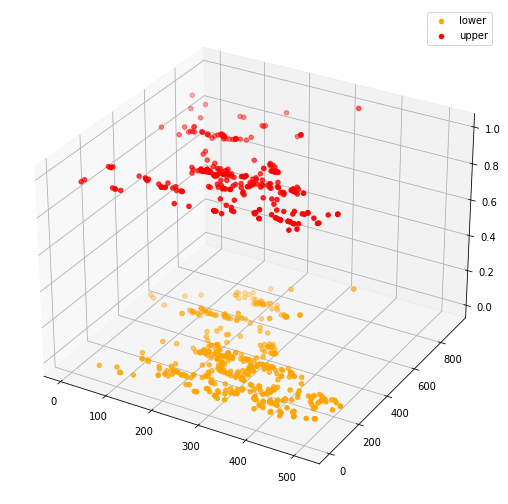

In [13]:
fig = plt.figure(figsize=(x_size*2.5,y_size))
ax = plt.axes(projection='3d',elev=29)

color_dict = {'upper':'red','lower':'orange'}

for n,g in df.groupby('COMAH tier'):
    xs = g['x']
    ys = g['y']
    zs = g['z']
    ax.scatter(xs,ys,zs, 'gray',c=color_dict[n],label=n)
a = plt.legend()

# Clustering

- We now proceed with clustering, we have 4 alorithms to demonstrate.
- A summary of all the algorithms (processed as a batch) is shown at the end of the workbook

## K-Means

### X,Y coordinates only

In [4]:
def estimtate_KM_clusters(X):
    i_score=[]
    s_score=[]
    clusters = list(map(int,np.linspace(2,31,30)))
    for n in clusters:
        km = KMeans(n_clusters=n)
        km.fit(X)
        s_score.append(silhouette_score(X,km.labels_))
        i_score.append(km.inertia_)

    fig,ax = plt.subplots(1,2,figsize=(18,4))
    ax[0].set_title('Intertia')
    ax[0].plot(clusters,i_score)
    ax[1].set_title('Silhouette score')
    ax[1].plot(clusters,s_score)
    r = list(map(list,zip(clusters,s_score)))[1:15]
    x,y = max(r,key=lambda x: x[1])
    ax[1].text(x,y*1.01,round(x,1),c='red')
    plt.show()

In [5]:
def process_KM_results(model,X):
    labels = model.labels_
    centers = model.cluster_centers_
    df_centers = pd.DataFrame(centers)
    df_labels = pd.concat([X,pd.Series(labels,name='label')],axis=1)
    return df_centers,df_labels

In [6]:
def plot_KM_cluster_map(df,df_centers,df_labels,title):
    x_size = 5
    y_size = x_size * df['y'].max()/df['x'].max() 
    fig,ax = plt.subplots(1,2,figsize=(x_size,y_size))
    
    for i,items in enumerate(df_labels.groupby('label')):
        n,g = items
        if n == -1:
            g.plot(marker='+',linestyle='',alpha=0.5,x='x',y='y',label=n,ax=ax[0],c='k')
        else: 
            g.plot(marker='o',linestyle='',alpha=0.35,x='x',y='y',label=n,ax=ax[0],zorder=1)
            ax[0].scatter(df_centers.iloc[i,0],df_centers.iloc[i,1],marker='*',s=1000,ec='k',zorder=2)
    ax[0].legend()
    ax[0].set_title(title)
    
    df.plot(kind='scatter',x='x',y='y',figsize=(x_size*2.5,y_size),alpha=0.35,title='COMAH Sites in x,y coords',ax=ax[1])
    
    plt.subplots_adjust(wspace=0.5)

- For KMeans we first must chose a suitable number of cluters.
- We are using the inertia (sum of squared error) and silhouette score (cluster cohesion) to help us identify this.

In [7]:
X = df[['x','y']]

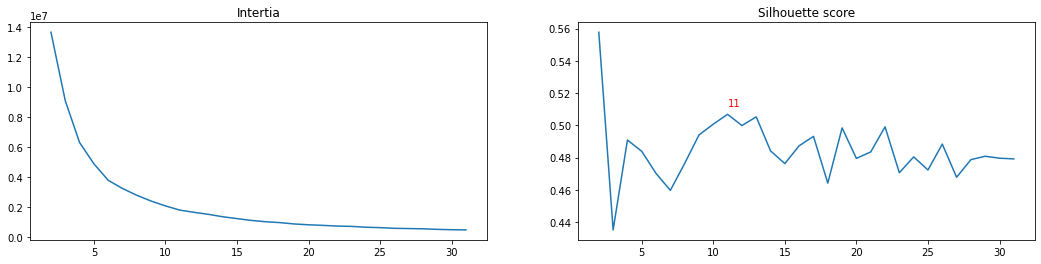

In [8]:
estimtate_KM_clusters(X)

- We now create a KMeans model and fit our data to this.
- The clusters are indicated by the legend, the center of each is shown with a star.

In [9]:
km = KMeans(n_clusters=12)
km.fit(X)

KMeans(n_clusters=12)

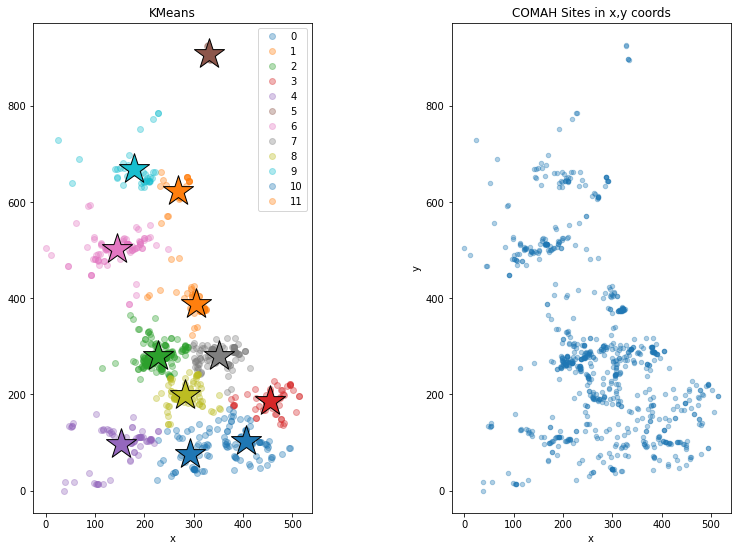

In [10]:
df_centers,df_labels = process_KM_results(km,X)
plot_KM_cluster_map(df,df_centers,df_labels,'KMeans')

### Include Tier data

- We mentioned earlier about the inclusion of the third dimension; tier. Here we include this to demonstrate the impact on the clusters.
- Note that now we are clustering on three dimensions, and viewing on a 2D plane, we may be unable to visually recognise some of the clusters.
- Because our tier is either a 1 or 0, we must there for make sure our other features are on the same scale, therefore we normalise our data.

In [14]:
X = df[['x','y']]
import sklearn.preprocessing as pp
Xn = pp.normalize(X,norm='l2')

In [15]:
zs = df['z'].values
zs = zs.reshape((800,1))
Xn = np.concatenate((Xn,zs),axis=1)
Xn = pd.DataFrame(Xn,columns=['x','y','z'])

In [16]:
Xn.head()

,x,y,z
0,0.870512,0.492148,1.0
1,0.692547,0.721373,1.0
2,0.358350,0.933587,1.0
3,0.801426,0.598094,1.0
4,0.612476,0.790489,1.0


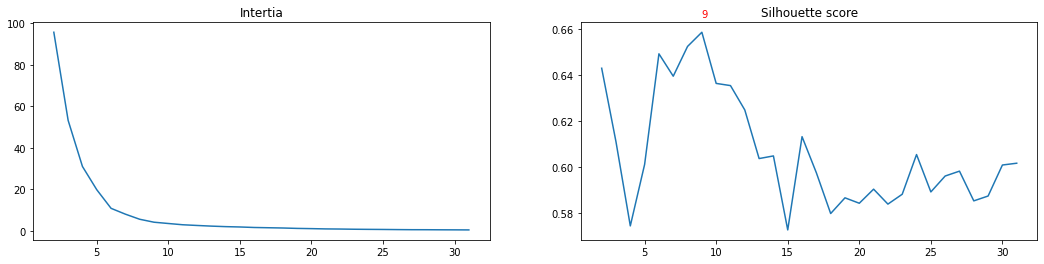

In [17]:
estimtate_KM_clusters(Xn)

In [18]:
km = KMeans(n_clusters=9)
km.fit(Xn)

KMeans(n_clusters=9)

In [19]:
def plot_KM_cluster_map(df,df_centers,df_labels,title,tiers=False):
    x_size = 5
    y_size = x_size * df['y'].max()/df['x'].max() 
    
    if tiers:
        df_tiers = pd.concat([df,df_labels['label']],axis=1)
        tier_dict = dict(df_tiers.groupby('label').apply(lambda g: g['COMAH tier'].value_counts(normalize=False)).index)
    
    fig,ax = plt.subplots(1,2,figsize=(x_size,y_size))
    
    for i,items in enumerate(df_labels.groupby('label')):
        n,g = items
        if n == -1:
            g.plot(marker='+',linestyle='',alpha=0.5,x='x',y='y',label=n,ax=ax[0],c='k')
        else: 
            g.plot(marker='o',linestyle='',alpha=0.35,x='x',y='y',label=n,ax=ax[0],zorder=1)
            ax[0].scatter(df_centers.iloc[i,0],df_centers.iloc[i,1],marker='*',s=1000,ec='k',zorder=2)
    ax[0].legend()
    ax[0].set_title(title)
    
    df.plot(kind='scatter',x='x',y='y',figsize=(x_size*2.5,y_size),alpha=0.35,title='COMAH Sites in x,y coords',ax=ax[1])
    
    plt.subplots_adjust(wspace=0.5)

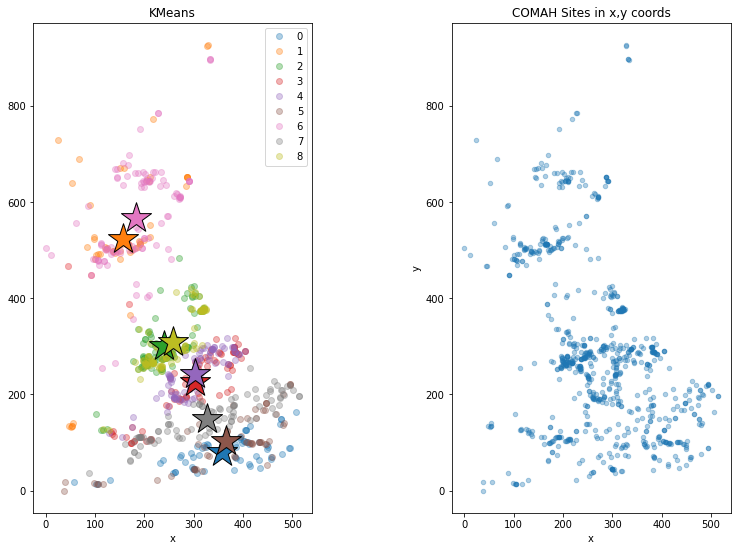

In [20]:
df_centers,df_labels = process_KM_results(km,X)
# we must manually create the centroid as the model centers returns normalised values
df_centers = df_labels.groupby('label').mean()
plot_KM_cluster_map(df,df_centers,df_labels,'KMeans')

- We now show varous other algorithms

## DBSCAN

In [43]:
dbs = DBSCAN(eps=25,min_samples=10,metric='euclidean')
dbs.fit(X)
labels = dbs.labels_
df_c = pd.concat([X,pd.Series(labels,name='label')],axis=1)

In [44]:
df_centers = df_c.groupby('label').mean()

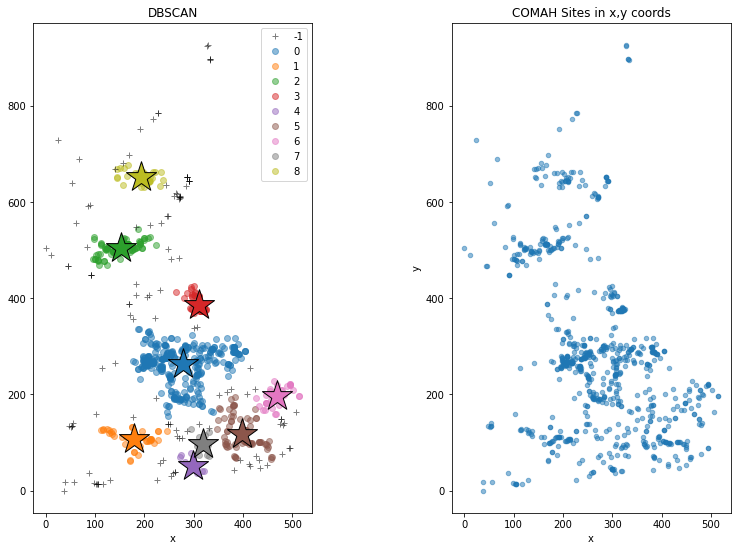

In [45]:
fig,ax = plt.subplots(1,2,figsize=(x_size,y_size))
for i, items in enumerate(df_c.groupby('label')):
    n,g = items
    if n == -1:
        g.plot(marker='+',linestyle='',alpha=0.5,x='x',y='y',label=n,ax=ax[0],c='k')
    else: 
        g.plot(marker='o',linestyle='',alpha=0.5,x='x',y='y',label=n,ax=ax[0],zorder=1)
        ax[0].scatter(df_centers.iloc[i,0],df_centers.iloc[i,1],marker='*',s=1000,ec='k',zorder=2)
ax[0].legend()
ax[0].set_title('DBSCAN')
df.plot(kind='scatter',x='x',y='y',figsize=(x_size*2.5,y_size),alpha=0.5,title='COMAH Sites in x,y coords',ax=ax[1])
plt.subplots_adjust(wspace=0.5)

## Affinity Propagation

In [27]:
ap = AffinityPropagation().fit(X)

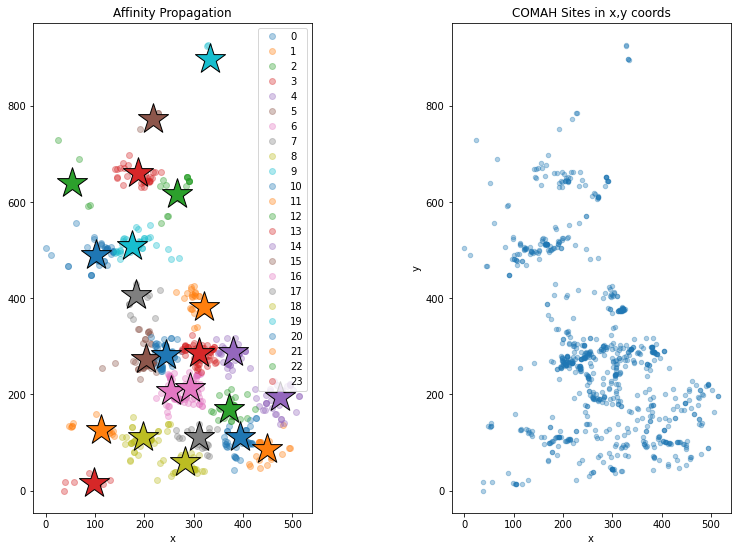

In [28]:
df_centers,df_labels = process_KM_results(ap,X)
plot_KM_cluster_map(df,df_centers,df_labels,'Affinity Propagation')

## Agglomerative Clustering

In [30]:
agc = AgglomerativeClustering(n_clusters=9).fit(X)
labels = agc.labels_
df_c = pd.concat([X,pd.Series(labels,name='label')],axis=1)

In [31]:
df_centers = df_c.groupby('label').mean()

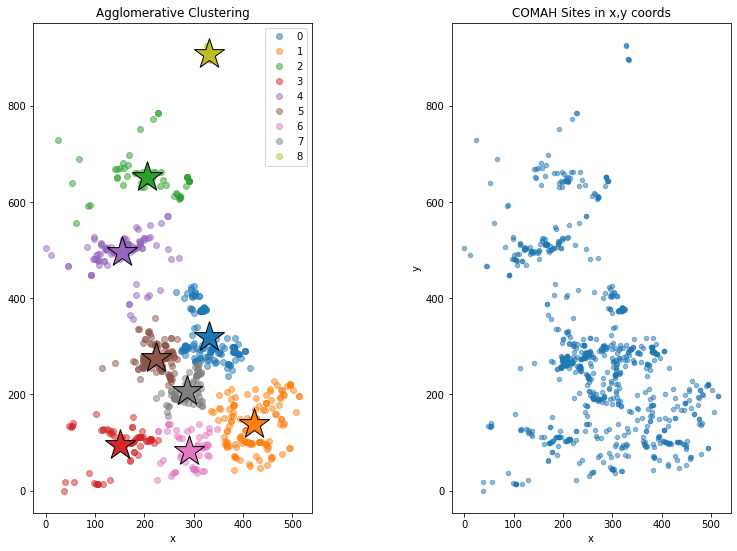

In [32]:
fig,ax = plt.subplots(1,2,figsize=(x_size,y_size))
for i, items in enumerate(df_c.groupby('label')):
    n,g = items
    if n == -1:
        g.plot(marker='+',linestyle='',alpha=0.5,x='x',y='y',label=n,ax=ax[0],c='k')
    else: 
        g.plot(marker='o',linestyle='',alpha=0.5,x='x',y='y',label=n,ax=ax[0],zorder=1)
        ax[0].scatter(df_centers.iloc[i,0],df_centers.iloc[i,1],marker='*',s=1000,ec='k',zorder=2)
ax[0].legend()
ax[0].set_title('Agglomerative Clustering')
df.plot(kind='scatter',x='x',y='y',figsize=(x_size*2.5,y_size),alpha=0.5,title='COMAH Sites in x,y coords',ax=ax[1])
plt.subplots_adjust(wspace=0.5)

# Group comparison

- Whist we have created each graph individually with a lot of code, in practise we would create all models in batch and compare in a more consise way.

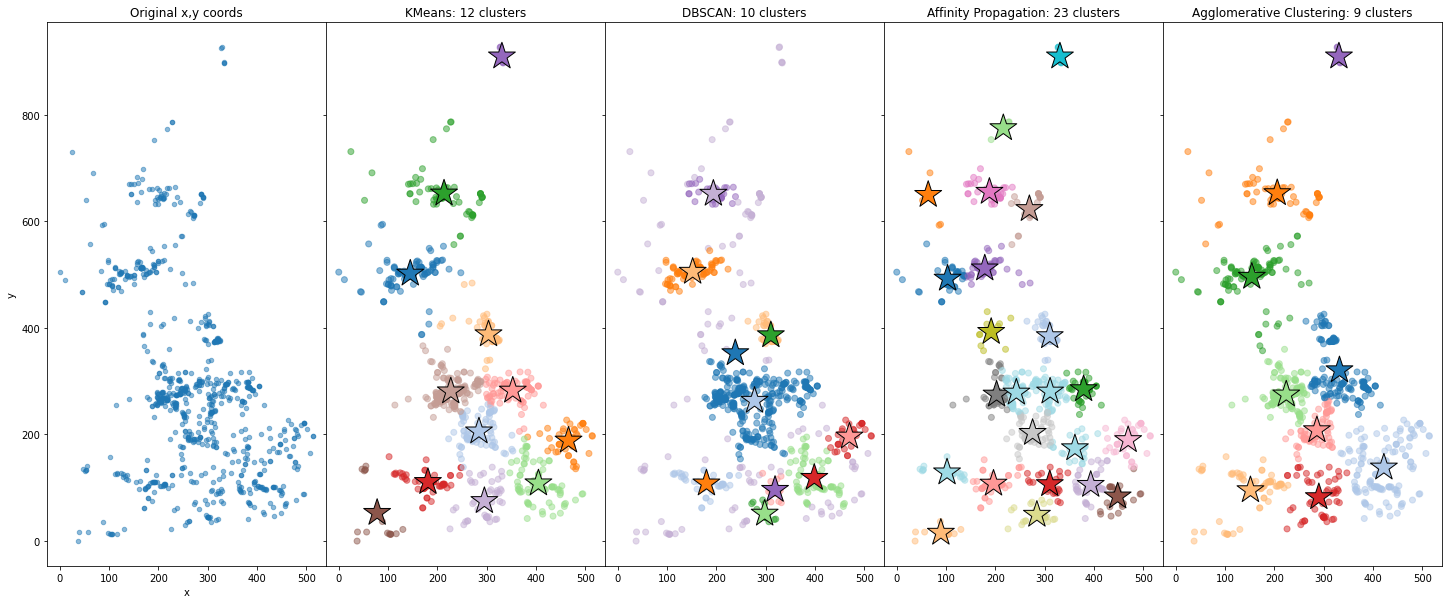

In [47]:
import warnings
warnings.simplefilter('ignore')
cmap = plt.get_cmap('tab20')

algorithms = {'KMeans':                   KMeans(n_clusters=12),
              'DBSCAN':                   DBSCAN(eps=25,min_samples=10,metric='euclidean'),
              'Affinity Propagation':     AffinityPropagation(),
              'Agglomerative Clustering': AgglomerativeClustering(n_clusters=9)}

fig,ax=plt.subplots(1,5,figsize=(25,10),sharey=True) #x_size,y_size

for i,items in enumerate(algorithms.items()):
    name, algorithm = items
    algorithm.fit(X)
    if hasattr(algorithm, 'labels_'):
            labels = algorithm.labels_
            # get colors
            unique_labels = set(labels)
            colors = cmap(np.arange(len(unique_labels)))
            color_dict = dict(map(list,zip(unique_labels,colors)))
            label_colors = [color_dict[l] for l in labels]
        
    X_labels = pd.concat([X,pd.Series(labels,name='label')],axis=1)
    df_centers = X_labels.groupby('label').mean()

    ax[i+1].scatter(x=X['x'],y=X['y'],marker='o',alpha=0.5,label=None,zorder=1,color=label_colors)
    ax[i+1].scatter(df_centers['x'],df_centers['y'],marker='*',s=800,ec='k',zorder=2,color=colors)
    ax[i+1].set_title(name+': '+str(len(unique_labels))+' clusters')
    
df.plot(kind='scatter',x='x',y='y',alpha=0.5,title='Original x,y coords',ax=ax[0])
plt.subplots_adjust(wspace=0.0)

# Conclusion

- We can clearly see that the COMAH sites have geographical clusters. We could have even does this without machine learning methods.
- However, this notebook has introduced the concept of clustering on an interpretable data set. 
- The next steps will be to introduce data other than x,y, coordinates, such as hazardous material information to see if this produces new clusters, and to see if this data can be used to predict the tier of the COMAH site.